### *Localisation optimale des capacités de production éoliennes en Europe*

Notebook pour le  chargement des données du projet (partie I) -- version 1.2 (màj le 31/3/2020)

In [43]:
## imports classiques
import numpy as np

from cylp.cy import CyClpSimplex
from cylp.py.modeling.CyLPModel import CyLPArray, CyLPModel

import matplotlib.pyplot as plt
import math 
import pandas as pd
import plotly.graph_objects as go
import matplotlib.colors as colors
import random


colors_list = list(colors._colors_full_map.values())
random.shuffle(colors_list)

%matplotlib notebook

In [44]:
## paramètres

liste_pays = ['Allemagne','Autriche','Belgique','Danemark','Espagne','France','Irlande','Italie','Luxembourg',\
             'Norvège','Pays-Bas','Portugal','Royaume-Uni','Suède','Suisse']

liste_pays_index_dic = {'Allemagne':0,'Autriche':1,'Belgique':2,'Danemark':3,'Espagne':4,'France':5,'Irlande':6,'Italie':7,'Luxembourg':8,\
             'Norvège':9,'Pays-Bas':10,'Portugal':11,'Royaume-Uni':12,'Suède':13,'Suisse':14}

list_colors_dic = {'Allemagne':colors_list[0],'Autriche':colors_list[1],'Belgique':colors_list[2],'Danemark':colors_list[3],'Espagne':colors_list[4],\
                         'France':colors_list[5],'Irlande':colors_list[6],'Italie':colors_list[7],'Luxembourg':colors_list[8],\
             'Norvège':colors_list[9],'Pays-Bas':colors_list[10],'Portugal':colors_list[11],'Royaume-Uni':colors_list[12],'Suède':colors_list[13],'Suisse':colors_list[14]} 

TURB = np.array([8587 , 12009 , 1417 , 9 , 18372 , 25132 , 527 , 21117 , 1140 , 28941 , 37 , 5052 , 4269 , 16637 , 15101])
POMP = np.array([5223 , 3580 , 1307 , 0 , 5347 , 4303 , 292 , 7544 , 1100 , 1396 , 0 , 1029 , 2744 , 45 , 1636 ])
RES = np.array([0.3*1e6 , 3.2*1e6 , 0.01*1e6 , 0 , 18.4*1e6 , 9.8*1e6 , 0.24*1e6 , 7.9*1e6 , 0.005*1e6 , 84.147*1e6 , 0 , 2.6*1e6 , 1.2*1e6 , 33.756*1e6 , 8.4*1e6])

N_pays = 15                  # plus petit ou égal à N_pays_max = 15
N_sites = 642                # plus petit ou égal à sites_max = 642
N_heures_par_annee = 24*365  # nombre d'heures par année
N_annees = 1/12              # fraction de l'annee à utiliser ; prendre par exemple 1/12 pour tester sur un mois (calculs 
                             # plus rapides) ; dans le rapport il faut utiliser l'année complète N_annees = 1
#N_heures = int(np.ceil(N_heures_par_annee*N_annees)) # nombre d'heures à extraire des fichiers de rendements
N_heures = 732

vecteur_temps = np.arange(1,N_heures+1) / N_heures_par_annee

In [45]:
## chargement et traitement des données brutes (I)
 
sites = pd.read_csv('Sites.csv', index_col = "index site").sort_index()

onshore = sites[sites['capacite offshore']=='Non'].copy()
offshore = sites[sites['capacite offshore']=='Oui'].copy()

In [46]:
sites.head()

,latitude,longitude,pays,couleur,capacite offshore,scores,capacites
index site,,,,,,,
0,54.0,7.0,Allemagne,#7b0323,Oui,0.006342,8364.150000
1,54.0,8.0,Allemagne,#7b0323,Non,0.003291,7509.607003
2,54.0,9.0,Allemagne,#7b0323,Non,0.002193,5003.709632
3,54.0,10.0,Allemagne,#7b0323,Non,0.001852,4225.781588
4,54.0,11.0,Allemagne,#7b0323,Non,0.001852,4225.781588


In [47]:
onshore.head()

,latitude,longitude,pays,couleur,capacite offshore,scores,capacites
index site,,,,,,,
1,54.0,8.0,Allemagne,#7b0323,Non,0.003291,7509.607003
2,54.0,9.0,Allemagne,#7b0323,Non,0.002193,5003.709632
3,54.0,10.0,Allemagne,#7b0323,Non,0.001852,4225.781588
4,54.0,11.0,Allemagne,#7b0323,Non,0.001852,4225.781588
5,54.0,12.0,Allemagne,#7b0323,Non,0.002193,5003.709632


In [48]:
offshore.head()

,latitude,longitude,pays,couleur,capacite offshore,scores,capacites
index site,,,,,,,
0,54.0,7.0,Allemagne,#7b0323,Oui,0.006342,8364.150000
48,56.0,5.0,Danemark,#A9A9A9,Oui,0.010571,15478.589744
49,55.0,6.0,Allemagne,#7b0323,Oui,0.010571,13940.250000
61,52.0,3.0,Pays-Bas,#04d8b2,Oui,0.006342,2349.264706
66,58.0,10.0,Suède,#758da3,Oui,0.006342,8577.125000


In [49]:
# Visualisations des données pour les sites 

"""fig = go.Figure(data=go.Scattergeo(
        lon = offshore['longitude'],
        lat = offshore['latitude'],
        text = offshore['pays'],
        mode = 'markers',
        marker=dict(
        color = offshore['couleur'],
        size = offshore['scores']*1000)
        ))

fig.update_layout(
        title = 'Sites offshore, et leur importance',
        geo_scope = 'europe'
    )
fig.show();"""

"fig = go.Figure(data=go.Scattergeo(\n        lon = offshore['longitude'],\n        lat = offshore['latitude'],\n        text = offshore['pays'],\n        mode = 'markers',\n        marker=dict(\n        color = offshore['couleur'],\n        size = offshore['scores']*1000)\n        ))\n\nfig.update_layout(\n        title = 'Sites offshore, et leur importance',\n        geo_scope = 'europe'\n    )\nfig.show();"

In [50]:
"""fig = go.Figure(data=go.Scattergeo(
        lon = onshore['longitude'],
        lat = onshore['latitude'],
        text = onshore['pays'],
        mode = 'markers',
        marker=dict(
        color = onshore['couleur'],
        size = onshore['scores']*3000)
        ))

fig.update_layout(
        title = 'Sites onshore, et leur importance',
        geo_scope = 'europe'
    )
fig.show();"""

"fig = go.Figure(data=go.Scattergeo(\n        lon = onshore['longitude'],\n        lat = onshore['latitude'],\n        text = onshore['pays'],\n        mode = 'markers',\n        marker=dict(\n        color = onshore['couleur'],\n        size = onshore['scores']*3000)\n        ))\n\nfig.update_layout(\n        title = 'Sites onshore, et leur importance',\n        geo_scope = 'europe'\n    )\nfig.show();"

In [51]:
"""fig = go.Figure(data=go.Scattergeo(
        lon = sites['longitude'],
        lat = sites['latitude'],
        text = sites['pays'],
        mode = 'markers',
        marker_color = sites['couleur'],
        marker = dict(size = 2),
        ))

fig.update_layout(
        title = 'Affectation par pays des sites éoliens',
        geo_scope = 'europe'
    )
fig.show();"""

"fig = go.Figure(data=go.Scattergeo(\n        lon = sites['longitude'],\n        lat = sites['latitude'],\n        text = sites['pays'],\n        mode = 'markers',\n        marker_color = sites['couleur'],\n        marker = dict(size = 2),\n        ))\n\nfig.update_layout(\n        title = 'Affectation par pays des sites éoliens',\n        geo_scope = 'europe'\n    )\nfig.show();"

In [52]:
"""fig = go.Figure(data=go.Scattergeo(
        lon = sites['longitude'],
        lat = sites['latitude'],
        text = 'pays: '+sites['pays']+', offshore: '+sites['capacite offshore']+' | capacite [MW] = '+\
        sites['capacites'].astype(str),
        mode = 'markers',
        marker = dict(
            color = sites['couleur'],
            size = sites['capacites']/sites['capacites'].max() * 30)
        ))

fig.update_layout(
        title = 'Capacites des sites éoliens',
        geo_scope = 'europe'
    )
fig.show();"""

"fig = go.Figure(data=go.Scattergeo(\n        lon = sites['longitude'],\n        lat = sites['latitude'],\n        text = 'pays: '+sites['pays']+', offshore: '+sites['capacite offshore']+' | capacite [MW] = '+        sites['capacites'].astype(str),\n        mode = 'markers',\n        marker = dict(\n            color = sites['couleur'],\n            size = sites['capacites']/sites['capacites'].max() * 30)\n        ))\n\nfig.update_layout(\n        title = 'Capacites des sites éoliens',\n        geo_scope = 'europe'\n    )\nfig.show();"

In [53]:
# chargement et traitement des données brutes (II)
rend_offshore_brut = np.genfromtxt('Rendements_offshore.csv', delimiter=',')[:,:N_heures]
rend_onshore_brut = np.genfromtxt('Rendements_onshore.csv', delimiter=',')[:,:N_heures]

print(rend_offshore_brut.shape)
print(rend_onshore_brut.shape)

(642, 732)
(642, 732)


In [54]:
indice_offshore= offshore.index
indice_onshore= onshore.index

In [55]:
rend_sites_matrix = rend_onshore_brut.copy()   # matrix combinant les valeurs réelles onshore/offshore -> souci de visibilité ci-dessous
for i in np.array(indice_offshore):
    rend_sites_matrix[i] = rend_offshore_brut[i]
#print(rend_sites_matrix)
#print(rend_sites_matrix[443][0] == rend_offshore_brut[443][0])

# Matrice 3D (nombres de sitesXnombres d'intervallesXpas) 
adpt = rend_sites_matrix.copy().reshape(N_sites, N_heures//3, 3)
#print(adpt)

# Matrice 2D (nombres de sitesXnombres d'intervalles)
sum2D = np.sum(adpt, axis = 2)
print(len(sum2D[0]))
print(sum2D)

sum2Dbis = sum2D.copy()
last = sum2Dbis[:,-1]
sum2Dbis = np.delete(sum2Dbis, np.s_[-1],  1)
sum2Dbis = np.insert(sum2Dbis,0, last, axis = 1)
print(len(sum2Dbis[0]))
print(sum2Dbis)

diff = sum2Dbis - sum2D
print(diff.shape)
a = np.array([2,3,4,5,6,7])
print(a[1:])

244
[[2.53174    2.67       2.67       ... 1.97972    1.63783    1.20162   ]
 [0.61915    1.2167     2.11155    ... 2.70167    2.60668    2.3129    ]
 [2.76648    2.80416    2.74107    ... 1.52751    1.72501    1.68017   ]
 ...
 [2.6472     1.89716    1.21242    ... 0.69577    0.362663   0.12717   ]
 [0.69489    0.142022   0.0406452  ... 0.0487501  0.095049   0.058117  ]
 [0.         0.         0.00451312 ... 0.98189    1.06166    0.86361   ]]
244
[[1.20162   2.53174   2.67      ... 2.28955   1.97972   1.63783  ]
 [2.3129    0.61915   1.2167    ... 2.735     2.70167   2.60668  ]
 [1.68017   2.76648   2.80416   ... 1.22431   1.52751   1.72501  ]
 ...
 [0.12717   2.6472    1.89716   ... 1.14926   0.69577   0.362663 ]
 [0.058117  0.69489   0.142022  ... 0.0033056 0.0487501 0.095049 ]
 [0.86361   0.        0.        ... 0.77638   0.98189   1.06166  ]]
(642, 244)
[3 4 5 6 7]


In [76]:
#TODO contraince active, variable =0
#TODO signature de la fonction

def attribution_puissance(P = 500000, kappa = 0.17, delta = 0.02, T = 3):
    s = CyClpSimplex()
    
    # Add variables
    x = s.addVariable('x', N_sites)
    
    # Add constraints
    p_max = CyLPArray(sites["capacites"])
    s += 0 <= x <= p_max
    
    s += x.sum() == P
    
    offshorearray = np.zeros(N_sites)
    offshorearray[indice_offshore] = 1             # set à 1 les sites offshore
    s += (CyLPArray(offshorearray)*x) == kappa*P
    
    n_interval = N_heures//T  # nombre d'intervalle sur les heures imparties
    L = s.addVariable('l', n_interval)  # vecteur L de longeur n_interval pour gérer valeurs absolues 
    
    sum_array = np.sum(rend_sites_matrix.copy().reshape(N_sites, n_interval, T), axis = 2)
    sum_array_shifted = sum_array.copy()
    last = sum_array_shifted[:,-1]
    sum_array_shifted = np.delete(sum_array_shifted, np.s_[-1],  1)
    sum_array_shifted = np.insert(sum_array_shifted,0, last, axis = 1)
    diff = np.asmatrix(sum_array_shifted - sum_array).transpose()
    print ("diff.shape : ",diff.shape)
    s += diff*x - L <= 0
    s += -diff*x - L <= 0
    print("A droite : ",delta*P*(n_interval-1)*T)
    s += L.sum() <= delta*P*(n_interval-1)*T  # contrainte de variabilité
    
    #print ("\nConstraints :\n", s.constraints)
    #print ("\nConstraintMatrix :\n", s.coefMatrix)
    
    # Set the objective function
    c = -CyLPArray(np.sum(rend_sites_matrix, axis = 1))
    
    s.objective = c * x
    #print("\nc = ",s.objective)
    
    # Solve using primal Simplex
    s.primal()
    
    # Return values
    return s.primalVariableSolution['x'], -s.objectiveValue, s.getStatusString(), s.primalVariableSolution['l']
    
## Solutions ##

PUISSANCE_INSTALLEE, ENERGIE_TOTALE, type_sol, l_sol = attribution_puissance(500000,0.17,0.02,3)

print ("\nlsol = ",l_sol) 
print ("\nPuissance installée = ",PUISSANCE_INSTALLEE) 
print("\nEnergie totale = ", ENERGIE_TOTALE, "MWh") #192644543.2528026
print("\nEtat de la solution ? = ", type_sol)

diff.shape :  (244, 642)
A droite :  7290000.0

lsol =  [ 2.69232973e+05  1.85557293e+04  4.26131038e+04  3.84358753e+04
  6.65640313e+04  3.31007665e+04  4.45170643e+04  4.65382475e+04
  4.09666216e+04  3.25770813e+04  3.29323402e+02  6.95712992e+04
  6.45228913e+04  4.13240280e+04  4.42330614e+04  3.38622725e+04
  1.10932040e+04  1.90053902e+04  2.68374414e+04  1.22260132e+04
  3.65647244e+04  9.60024344e+04  4.73547149e+04  3.81588427e+04
  1.18288883e+04  2.30654428e+04  2.57243415e+04  9.03071047e+04
  1.04340281e+05  9.36430381e+04  2.84603614e+04  3.25189673e+04
  2.03524161e+04  3.35086495e+04  5.03444827e+03  3.67736618e+04
  1.87407215e+04  2.20993715e+04  1.36773142e+04  4.53083456e+04
  3.58667928e+04  6.03604521e+04  3.14269258e+04  2.79016698e+04
  4.29762870e+03  5.81013235e+04  3.86868162e+03  5.03772560e+04
  4.55477086e+04  2.07721255e+02  1.70750567e+04  1.89021484e+04
  5.76773214e+03  5.17973145e+04  8.80981622e+03  5.01947934e+04
  3.14928516e+04  4.15058268e+04  

In [77]:
#192647879.5800425
#192372783.36386815
print("Vérifications : ")
print("Somme des puissances installées = ", PUISSANCE_INSTALLEE.sum())
print("Somme des puissances installées (offshore) = ", PUISSANCE_INSTALLEE[indice_offshore].sum())

var = np.sum(l_sol)
print("Variabilité obtenue : ",var," != ", 0.02*500000*T*n_interval, " : Variabilité théorique")

Vérifications : 
Somme des puissances installées =  499999.99999999953
Somme des puissances installées (offshore) =  85000.0
Variabilité obtenue :  7289999.999999998  !=  7290000.0  : Variabilité théorique


# Début du programme de résolution simplex

Création du problème simplex.


Attribution des paramètres.

Paramètres généraux: 
    
$$ N \text{ Repésente ici le nombre de sites sur lesquels se porte notre étude.}$$

$$ H  \text{ Repésente la période sur laquelle se porte notre étude en heure.} $$

$$ P  \text{ Représente la puissance totale à installer en MW.}$$

Paramètres pour la variabilité: 

$$ T  \text{ Définit un pas de temps pour l'étude de la variabilité.}$$

$$ \delta  \text{ Définit le ratio toléré entre deux périodes de temps T consécutives.}$$

Paramètres pour la répartition des sites:

$$ \kappa  \text{ Est la proportion de production se faisant en site offshore.}$$



Ajout du vecteur variable $ x $.

Chaque élément $x_{i}$ de ce vecteur représente la puissance installée sur un site.

Ajout de la contrainte de positivité :

$$ x \geq 0 $$

Ajout de la contrainte sur la puissance totale installée:
$$ \sum_{i=1}^{N} x_{i} = P $$

Ajout de la contrainte sur la répartition offshore/onshore des sites.

$$
\sum_{i=1}^{N} \alpha_{i} x_{i} = \kappa P \\
\text{Avec : } \\
\begin{align}
\begin{cases}
\alpha_{i} = 1 & \text{ si $i$ est l'indice d'un site offshore}\\
\alpha_{i} = 0 & \text{ si $i$ est l'indice d'un site onshore}
\end{cases}
\end{align}
$$


Ajout de la contrainte sur la variabilité.
Initialement :
$$
\sum_{i=1}^{\frac{H}{T}-1} \frac{\sum_{j=1}^{N}x_{j}|\sum_{k=Ti+1}^{Ti+T} \eta_{jk}-\sum_{k=Ti+T+1}^{Ti+2T}\eta_{jk}|}{\frac{H}{T}-1} \leq \delta P\\
\text{où la matrice $\eta$ est la matrice des rendements dans laquelle chaque ligne correspond à un site et chaque colonne à une heure}
$$

Pour linéariser la contrainte nous avons introduit un nouveau vecteur de variables l et imposé les contraintes comme suit : 

$$
\sum_{j=1}^{N}x_{j}\sum_{k=Ti+1}^{Ti+T} \eta_{jk}-\sum_{k=Ti+T+1}^{Ti+2T}\eta_{jk} - l\leq 0\\
\sum_{j=1}^{N}x_{j}(-\sum_{k=Ti+1}^{Ti+T} \eta_{jk}+\sum_{k=Ti+T+1}^{Ti+2T}\eta_{jk}) - l \leq 0\\
\sum_{i=1}^{\frac{H}{T}-1} l_{i} \leq \delta P n_{interval}\\
\text{et}\\
n_{interval} = {\frac{H}{T}-1}
$$

Nous avons bien sûr également adapté les indices pour qu'ils satisfassent les attentes de Python.


Enfin, nous cherchons à maximiser notre fonction objectif:
$$
\text{max } \sum_{i=1}^{N}x_{i}\sum_{j=1}^{H}\eta_{ij}\\
\text{où la matrice $\eta$ est la matrice des rendements dans laquelle chaque ligne correspond à un site et chaque colonne à une heure}
$$

Pour nous adapter aux spécifications du module CyLP nous avons transformé notre max en min comme suit:

$$
\text{min } \sum_{i=1}^{N}x_{i}(-\sum_{j=1}^{H}\eta_{ij})\\
\text{où la matrice $\eta$ est la matrice des rendements dans laquelle chaque ligne correspond à un site et chaque colonne à une heure}
$$

Nous résolvons par la méthode du simplex et imprimons les valeurs de nos variables ainsi que de notre fonction objectif à l'optimum. 

In [16]:
rend_moyen = ENERGIE_TOTALE/(N_heures*500000)
print("Rendement moyen sur une année :", rend_moyen )

Rendement moyen sur une année : 0.5263603267214285


In [17]:
#TODO faire un dataframe panda pour classer les 10 meilleurs sites selon leurs rendements moyen sur l'année
#TODO variabilité des best sites (Est -ce que les best sites sont compatible savec la notion de variabilité 
#     ou alor est-ce qu'ils sont tres tres bons sur toutes l'année mais produisent beaucoup de maniere tres instable )

dict = {}
for i in range(len(rend_sites_matrix)):
    dict[i] = rend_sites_matrix[i].sum()

dict_sorted = sorted(dict.items(), key=lambda x: x[1],reverse=True)
dict_best = dict_sorted[:10]

index_best = np.zeros(10)
rendement_best = np.zeros(10)
for i in range(10):
    index_best[i] = dict_best[i][0]
    rendement_best[i]=(dict_best[i][1])/N_heures

classement = pd.DataFrame([],columns = sites.columns)

for i in range(10):
    ligne = sites[sites.index==index_best[i]]
    classement= classement.append(ligne)
del classement["couleur"]
del classement["scores"]
del classement["capacites"]
classement["rendement moyen"] = rendement_best
classement["différence"] = rendement_best - rend_moyen

classement.reset_index(drop=True, inplace=True) 

In [18]:
# Classement des meilleurs sites suivant leur rendement moyen
classement

,latitude,longitude,pays,capacite offshore,rendement moyen,différence
0,57.0,6.0,Danemark,Oui,0.705639,0.179278
1,57.0,7.0,Danemark,Oui,0.693775,0.167414
2,57.0,8.0,Danemark,Non,0.685381,0.159021
3,54.0,9.0,Allemagne,Non,0.671455,0.145094
4,57.0,5.0,Norvège,Oui,0.662672,0.136312
5,56.0,8.0,Danemark,Non,0.661150,0.134790
6,58.0,6.0,Norvège,Oui,0.657555,0.131194
7,56.0,6.0,Danemark,Oui,0.655823,0.129463
8,56.0,7.0,Danemark,Oui,0.655724,0.129364
9,54.0,7.0,Allemagne,Oui,0.653835,0.127475


diff.shape :  (244, 642)
A droite :  3645000.0
diff.shape :  (244, 642)
A droite :  5467500.0
diff.shape :  (244, 642)
A droite :  7290000.0
diff.shape :  (244, 642)
A droite :  9112500.0
diff.shape :  (244, 642)
A droite :  10935000.0
diff.shape :  (244, 642)
A droite :  12757500.0
diff.shape :  (244, 642)
A droite :  14580000.0


<IPython.core.display.Javascript object>


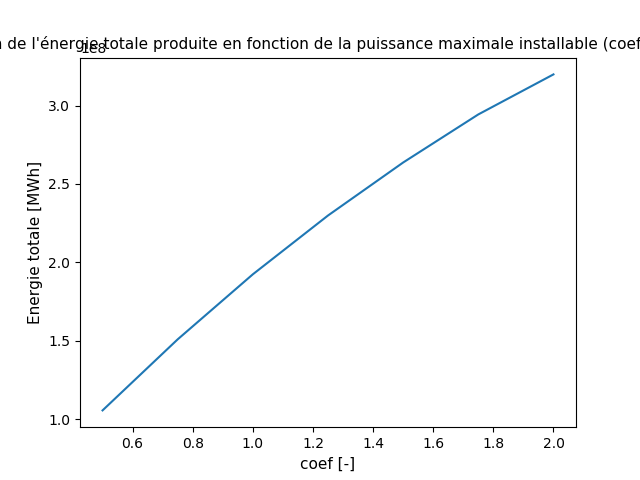

In [79]:
steps = 7
coef = np.linspace(0.5,2,steps)
puiss = np.zeros(steps)
for i in range (steps):
    puiss[i] = attribution_puissance(500000*coef[i])[1]

plt.plot(coef, puiss)
plt.title("Variation de l'énergie totale produite en fonction de la puissance maximale installable (coef * 500000)", fontsize=11)
plt.xlabel("coef [-]", fontsize=11)
plt.ylabel("Energie totale [MWh]", fontsize=11)

plt.show()

In [20]:
## Visualisation des rendements pour un pays

pays_test = 'France'
index_test = liste_pays_index_dic[pays_test]

# nombre de sites éoliens
index_sites_eoliens = sites[sites.pays==pays_test]['index site']
n_eoliens = len(index_sites_eoliens)
print('il y a '+str(n_eoliens)+' sites éoliens en '+str(pays_test))

# rendements eolien au hasard
random_site = np.random.choice(index_sites_eoliens)
plt.figure(figsize=(9,6))
plt.grid()
plt.title('rendement éolien: '+str(pays_test))
if sites.loc[random_site]['capacite offshore']=='Oui':
    plt.plot(vecteur_temps,matrice_rendements_offshore[random_site])
    plt.legend(['offshore'])
else:
    plt.plot(vecteur_temps,matrice_rendements_onshore[random_site])
    plt.legend(['onshore'])
plt.xlabel('temps : [années]')
plt.ylabel('rendement éolien: [/]')

print('rendement moyen offshore pour le pays: '+str(np.mean(matrice_rendements_offshore[index_sites_eoliens])))
print('rendement moyen onshore pour le pays: '+str(np.mean(matrice_rendements_onshore[index_sites_eoliens])))

# capacité éoliennes maximales tolérables
buf_ok_offshore = (sites.pays==pays_test) & (sites['capacite offshore']=='Oui')
buf_ok_onshore = (sites.pays==pays_test) & (sites['capacite offshore']=='Non')

print(' => capacité éolienne totale offshore : [MW] '+str(sites[buf_ok_offshore]['capacites'].sum()))
print(' => capacité éolienne totale offshore : [MW] '+str(sites[buf_ok_onshore]['capacites'].sum()))

# latitude/longitude
print('le pays '+str(pays_test)+' se trouve  à une latitude de '+str(sites.loc[random_site]['latitude'])+' et une longitude de '+\
      str(sites.loc[random_site]['longitude']))

KeyError: 'index site'

In [ ]:
indice_offshore= offshore.index
rend_offshore_matrix = rend_offshore_brut[indice_offshore]
rend_offshore_array = np.array([np.sum(rend_offshore_matrix[i]) for i in range(len(indice_offshore))])


indice_onshore= onshore.index
rend_onshore_matrix = rend_onshore_brut[indice_onshore]
rend_onshore_array = np.array([np.sum(rend_onshore_matrix[i]) for i in range(len(indice_onshore))])

maxoff= max(rend_offshore_array)
maxon = max(rend_onshore_array)

for i in range(len(rend_offshore_array)):
    if (rend_offshore_array[i] == max(rend_offshore_array) ) :
        print("Max offshore = {}  at  index = {} in offshore submatrix".format(maxoff,i))

for i in range(len(rend_onshore_array)):
    if (rend_onshore_array[i] == max(rend_onshore_array) ) : 
        print("Max onshore = {}  at  index = {} in onshore submatrix\n".format(maxon,i))
        
for i in range(642):
    if (rend_offshore_brut[i].sum() == maxoff):
        print("Max offshore = {}  at  index = {} in total matrix".format(maxoff,i))
    elif (rend_onshore_brut[i].sum() == maxon):
        print("Max onshore = {}  at  index = {} in total matrix".format(maxon,i))